# Prepare EEG data for training of machine-learning models
+ Import data.
+ Apply filters (bandpass).
+ Detect potential bad channels and replace them by interpolation.
+ Detect potential bad epochs and remove them.

## Import packages & links

In [145]:
# Import packages
import os
import sys

sys.path.insert(0, os.path.dirname(os.getcwd()))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mne

sns.set_theme(style="whitegrid")
%matplotlib inline
# %matplotlib qt

In [3]:
from config import PATH_CODE, PATH_RAW_DATA, PATH_METADATA, PATH_OUTPUT

## Search all *.cnt files and check for how many we have a label

In [5]:
import fnmatch
import warnings
import re
warnings.filterwarnings('ignore')

import helper_functions

# dir_names = {5: '5mnd mmn',
#              11: '11mnd mmn',
#              17: '17mnd mmn',
#              23: '23mnd mmn',
#              29: '29mnd mmn',
#              35: '35mnd mmn',
#              41: '41mnd mmn',
#              47: '47mnd mmn'}

dir_names = {17: '17mnd mmn',
             23: '23mnd mmn',
             29: '29mnd mmn',
             35: '35mnd mmn',
             41: '41mnd mmn'}
    
df_list = []

for age_group, directory in dir_names.items(): # Go into every age group folder        
    dir_path = os.path.join(PATH_RAW_DATA, directory)
    file_names = os.listdir(dir_path)
    cnt_paths = [os.path.join(dir_path, file_name) for file_name in fnmatch.filter(file_names, "*.cnt")]
    cnt_files = [x.split('/')[-1][:-4] for x in cnt_paths]
    codes = [int(re.search(r'\d+', x).group()) for x in cnt_files]
    df = pd.DataFrame(list(zip(codes, cnt_paths, cnt_files)), columns =['code', 'cnt_path','cnt_file']) 
    
    df['age_group'] = age_group
    df_list.append(df)

cnt_files = pd.concat(df_list)

In [6]:
cnt_files.head()

,code,cnt_path,cnt_file,age_group
0,1,/Volumes/Seagate Expansion Drive/ePodium/Data/...,001_17_jc_mmn36_slp_mmn25_slp_mmn47_slp_mmn58_slp,17
1,5,/Volumes/Seagate Expansion Drive/ePodium/Data/...,005_17_jc_mmn36_slp_mmn25_slp_mmn47_mixed,17
2,6,/Volumes/Seagate Expansion Drive/ePodium/Data/...,006_17_mc_mmn36_slp,17
3,7,/Volumes/Seagate Expansion Drive/ePodium/Data/...,007_17_jc_mmn,17
4,7,/Volumes/Seagate Expansion Drive/ePodium/Data/...,007_17_jc_mmn2,17


In [7]:
# age_files = {5: 'ages_5mnths.txt',
#              11: 'ages_11mnths.txt',
#              17: 'ages_17mnths.txt',
#              23: 'ages_23mnths.txt',
#              29: 'ages_29mnths.txt',
#              35: 'ages_35mnths.txt',
#              41: 'ages_41mnths.txt',
#              47: 'ages_47mnths.txt'}

age_files = {17: 'ages_17mnths.txt',
             23: 'ages_23mnths.txt',
             29: 'ages_29mnths.txt',
             35: 'ages_35mnths.txt',
             41: 'ages_41mnths.txt'}

df_list = []

for age_group, age_file in age_files.items():
    df = pd.read_csv(os.path.join(PATH_METADATA, 'ages', age_file), sep="\t")
    df['age_group'] = age_group
    df_list.append(df)

age_df = pd.concat(df_list)

### Merge the .cnt files with the age information we have on the subjects

In [8]:
merged_df = pd.merge(cnt_files, age_df, how='left', on=['age_group', 'code'])

In [9]:
merged_df.head()

,code,cnt_path,cnt_file,age_group,age_days,age_months,age_years
0,1,/Volumes/Seagate Expansion Drive/ePodium/Data/...,001_17_jc_mmn36_slp_mmn25_slp_mmn47_slp_mmn58_slp,17,NaN,NaN,NaN
1,5,/Volumes/Seagate Expansion Drive/ePodium/Data/...,005_17_jc_mmn36_slp_mmn25_slp_mmn47_mixed,17,507.0,16.9,1.408333
2,6,/Volumes/Seagate Expansion Drive/ePodium/Data/...,006_17_mc_mmn36_slp,17,NaN,NaN,NaN
3,7,/Volumes/Seagate Expansion Drive/ePodium/Data/...,007_17_jc_mmn,17,528.0,17.6,1.466667
4,7,/Volumes/Seagate Expansion Drive/ePodium/Data/...,007_17_jc_mmn2,17,528.0,17.6,1.466667


## Visualize the age ranges within groups

In [170]:
data_17 = merged_df.loc[merged_df['age_group'] == 17]
data_23 = merged_df.loc[merged_df['age_group'] == 23]
data_29 = merged_df.loc[merged_df['age_group'] == 29]
data_35 = merged_df.loc[merged_df['age_group'] == 35]
data_41 = merged_df.loc[merged_df['age_group'] == 41]
data = [data_17, data_23, data_29, data_35, data_41]

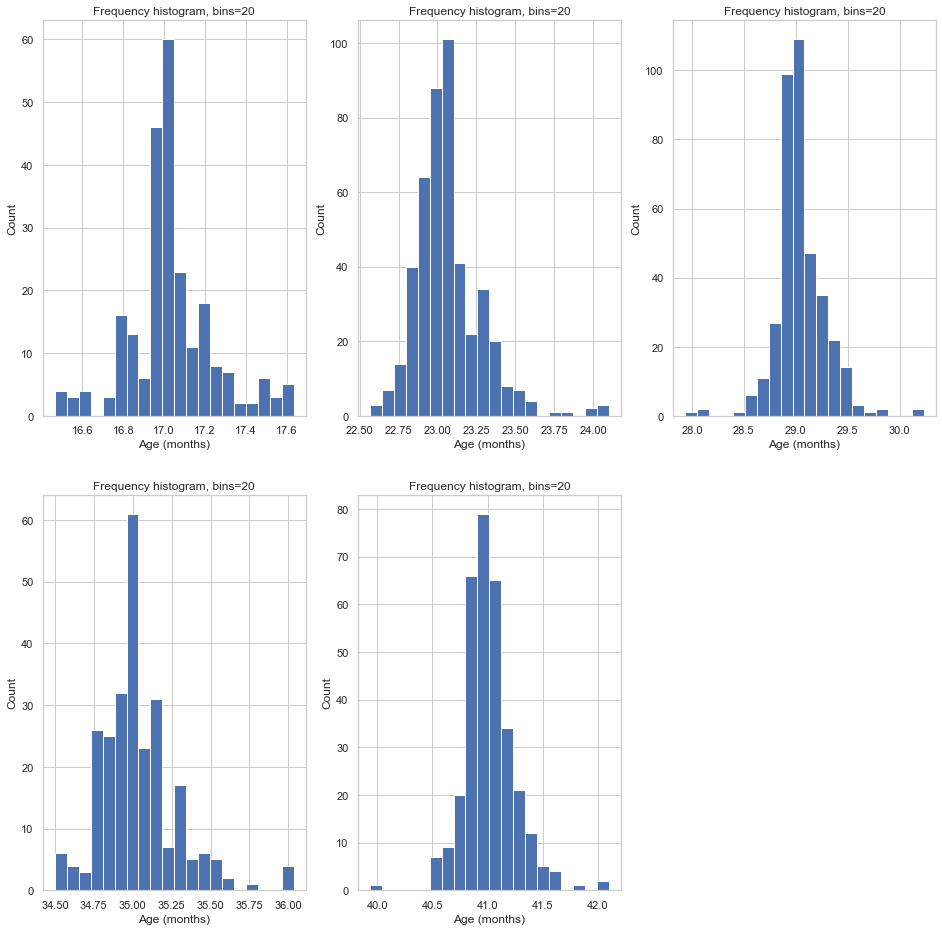

In [175]:
%matplotlib inline

bins = 20

fig, axes = plt.subplots(2, 3, figsize=(16,16))
for i, ax in enumerate(axes.flat):
    if i == len(data):
        ax.remove()
        break
    ax.hist(data[i]['age_months'], bins=bins)
    ax.set_xlabel('Age (months)')
    ax.set_ylabel('Count')
    ax.set_title(f'Frequency histogram, bins={bins}')

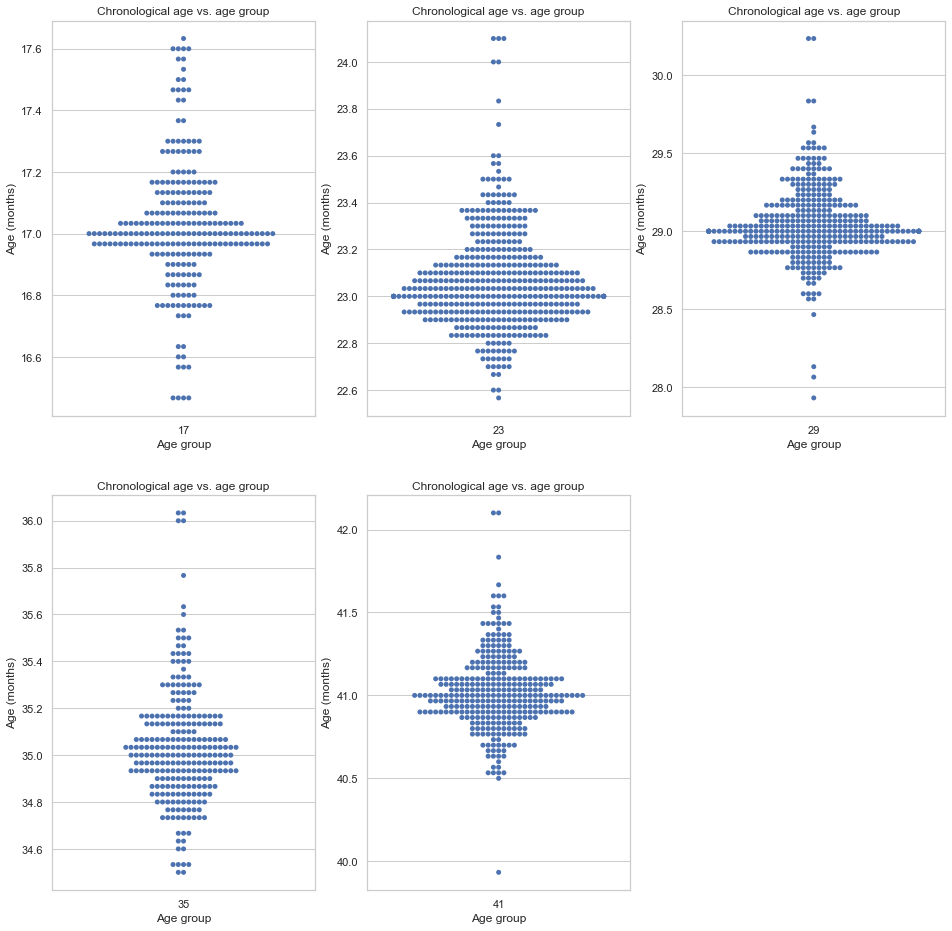

In [176]:
fig, axes = plt.subplots(2, 3, figsize=(16,16))
for i, ax in enumerate(axes.flat):
    if i == len(data):
        ax.remove()
        break
    sns.swarmplot(ax=ax, x="age_group", y="age_months", data=data[i])
    ax.set_xlabel('Age group')
    ax.set_ylabel('Age (months)')
    ax.set_title('Chronological age vs. age group')

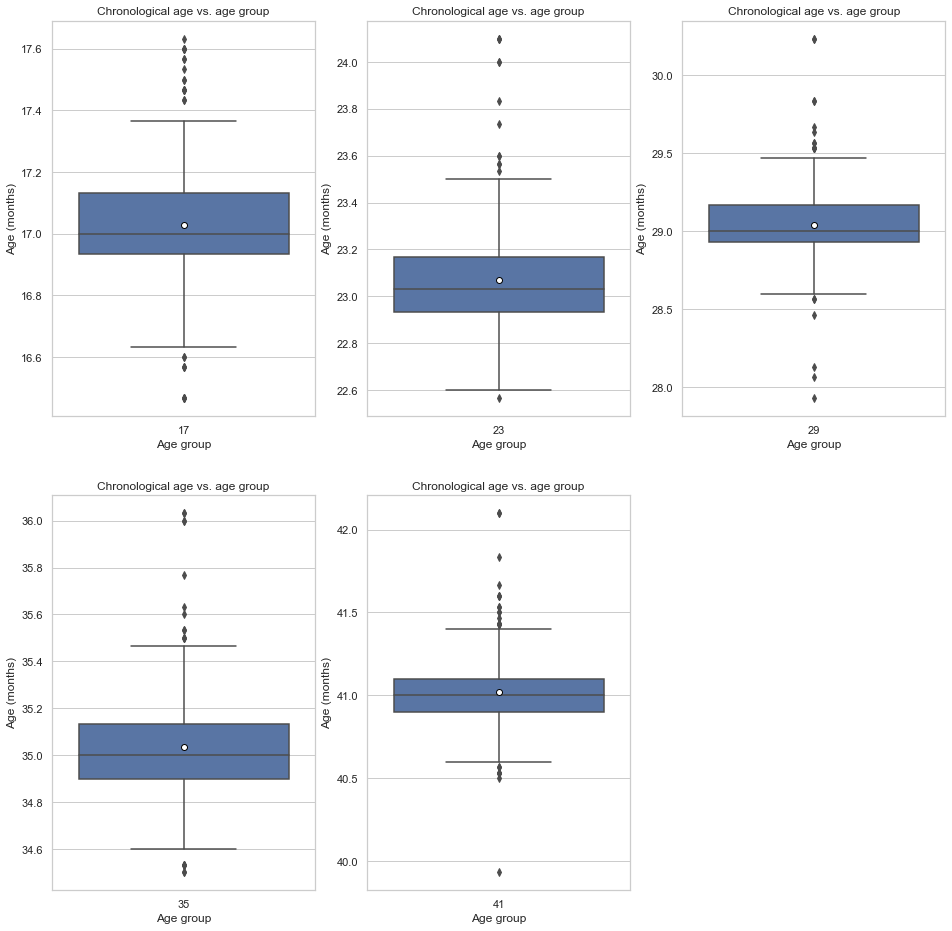

In [179]:
fig, axes = plt.subplots(2, 3, figsize=(16,16))
for i, ax in enumerate(axes.flat):
    if i == len(data):
        ax.remove()
        break
    sns.boxplot(ax=ax, x="age_group", y="age_months", data=data[i], showmeans=True, 
            meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"black",
                       "markersize":"6"})
    ax.set_xlabel('Age group')
    ax.set_ylabel('Age (months)')
    ax.set_title('Chronological age vs. age group')

## Check files with no label 

In [10]:
merged_df.loc[merged_df['age_days'].isnull()]

,code,cnt_path,cnt_file,age_group,age_days,age_months,age_years
0,1,/Volumes/Seagate Expansion Drive/ePodium/Data/...,001_17_jc_mmn36_slp_mmn25_slp_mmn47_slp_mmn58_slp,17,NaN,NaN,NaN
2,6,/Volumes/Seagate Expansion Drive/ePodium/Data/...,006_17_mc_mmn36_slp,17,NaN,NaN,NaN
65,126,/Volumes/Seagate Expansion Drive/ePodium/Data/...,126_17_mr_mmn,17,NaN,NaN,NaN
68,133,/Volumes/Seagate Expansion Drive/ePodium/Data/...,133_17_jr_mmn,17,NaN,NaN,NaN
103,149,/Volumes/Seagate Expansion Drive/ePodium/Data/...,149_17_mr_mmn25_slp,17,NaN,NaN,NaN
104,149,/Volumes/Seagate Expansion Drive/ePodium/Data/...,149_17_mr_mmn36_slp,17,NaN,NaN,NaN
105,149,/Volumes/Seagate Expansion Drive/ePodium/Data/...,149_17_mr_mmn47_slp,17,NaN,NaN,NaN
106,149,/Volumes/Seagate Expansion Drive/ePodium/Data/...,149_17_mr_mmn58_slp,17,NaN,NaN,NaN
133,165,/Volumes/Seagate Expansion Drive/ePodium/Data/...,165_17_jr_mmn25_slp,17,NaN,NaN,NaN
134,165,/Volumes/Seagate Expansion Drive/ePodium/Data/...,165_17_jr_mmn25_slp2,17,NaN,NaN,NaN


### Fill in the missing age data based on the age group the subject is in

In [11]:
merged_df['age_months'].fillna(merged_df['age_group'], inplace=True)
merged_df['age_days'].fillna(merged_df['age_group']*30, inplace=True)
merged_df['age_years'].fillna(merged_df['age_group']/12, inplace=True)

Below should now return an empty dataframe, because all empty fields have been filled

In [12]:
merged_df.loc[merged_df['age_days'].isnull()]

,code,cnt_path,cnt_file,age_group,age_days,age_months,age_years


In [13]:
merged_df

,code,cnt_path,cnt_file,age_group,age_days,age_months,age_years
0,1,/Volumes/Seagate Expansion Drive/ePodium/Data/...,001_17_jc_mmn36_slp_mmn25_slp_mmn47_slp_mmn58_slp,17,510.0,17.000000,1.416667
1,5,/Volumes/Seagate Expansion Drive/ePodium/Data/...,005_17_jc_mmn36_slp_mmn25_slp_mmn47_mixed,17,507.0,16.900000,1.408333
2,6,/Volumes/Seagate Expansion Drive/ePodium/Data/...,006_17_mc_mmn36_slp,17,510.0,17.000000,1.416667
3,7,/Volumes/Seagate Expansion Drive/ePodium/Data/...,007_17_jc_mmn,17,528.0,17.600000,1.466667
4,7,/Volumes/Seagate Expansion Drive/ePodium/Data/...,007_17_jc_mmn2,17,528.0,17.600000,1.466667
...,...,...,...,...,...,...,...
1661,751,/Volumes/Seagate Expansion Drive/ePodium/Data/...,751-452-41m-jr-mmn39langz,41,1229.0,40.966667,3.413889
1662,752,/Volumes/Seagate Expansion Drive/ePodium/Data/...,752-457-41m-jr-mmn39-langzaam,41,1238.0,41.266667,3.438889
1663,753,/Volumes/Seagate Expansion Drive/ePodium/Data/...,753-470-41m-mr-mmn39_snel,41,1240.0,41.333333,3.444444
1664,755,/Volumes/Seagate Expansion Drive/ePodium/Data/...,755-471-41m-mr-mmn39(langzaam),41,1236.0,41.200000,3.433333


## Explore EEG data

### Import EEG data (from .cnt files)

In [114]:
# Select a file
file = merged_df['cnt_path'][500] # just a random file number

# Import file 
data_raw = mne.io.read_raw_cnt(file, eog='auto', preload=True)

Reading 0 ... 363259  =      0.000 ...   726.518 secs...


## What does the data look like?

In [115]:
print('Data type: {}\n\n{}\n'.format(type(data_raw), data_raw))

# Get the sample rate
print('Sample rate:', data_raw.info['sfreq'], 'Hz')

# Get the size of the matrix
print('Size of the matrix: {}\n'.format(data_raw.get_data().shape))

# The mne.info class can be used to learn more about the data.
print(data_raw.info)

Data type: <class 'mne.io.cnt.cnt.RawCNT'>

<RawCNT | 445_23_md_mmn25_wk.cnt, 64 x 363260 (726.5 s), ~177.5 MB, data loaded>

Sample rate: 500.0 Hz
Size of the matrix: (64, 363260)

<Info | 8 non-empty values
 bads: []
 ch_names: O2, O1, OZ, PZ, P4, CP4, P8, C4, TP8, T8, P7, P3, CP3, CPZ, CZ, ...
 chs: 62 EEG, 2 EOG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 64
 projs: []
 sfreq: 500.0 Hz
 subject_info: 5 items (dict)
>


### Show data as pandas dataframe (i.e. as a table).
The raw data itself is just an array dimensions are no. of channels and timepoint.

In [16]:
raw_df = data_raw.to_data_frame()
raw_df.head()

,time,O2,O1,OZ,PZ,P4,CP4,P8,C4,TP8,...,F2,F6,FC5,F1,AF4,AF8,F5,AF7,AF3,FPZ
0,0,5.371094,21.148682,52.032471,-27.526855,4.699707,37.933350,-81.573486,-31.051636,-56.228638,...,-68.984985,-97.183228,-183.792114,-72.677612,-125.549316,-7.217407,-108.932495,-125.717163,-165.496826,45.318604
1,2,18.127441,16.952515,46.325684,-29.205322,7.049561,35.415649,-74.188232,-38.101196,-53.207397,...,-75.027466,-99.700928,-184.463501,-76.538086,-131.256104,-15.274048,-119.171143,-128.067017,-172.042847,45.654297
2,4,29.541016,16.113281,42.633057,-29.541016,10.238647,33.065796,-67.138672,-44.815063,-52.871704,...,-81.237793,-103.561401,-188.827515,-81.573486,-137.298584,-24.673462,-130.081177,-131.759644,-181.106567,42.465210
3,6,32.562256,24.337769,46.157837,-21.820068,17.456055,38.436890,-59.249878,-41.290283,-50.354004,...,-78.552246,-100.875854,-189.834595,-78.887939,-134.948730,-22.994995,-129.241943,-125.045776,-179.428101,42.800903
4,8,28.533936,41.458130,57.067871,-8.392334,26.351929,49.682617,-50.857544,-28.366089,-43.975830,...,-66.970825,-92.483521,-184.127808,-69.488525,-123.535156,-9.063721,-119.338989,-112.121582,-166.503906,48.004150


In [17]:
data_raw.info['bads']

[]

In [18]:
# Band-pass filter (between 1 and 40 Hz. was 0.5 to 30Hz in Stober 2016)
data_raw.filter(1, 40, fir_design='firwin')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 sec)



<RawCNT | 445_23_md_mmn25_wk.cnt, 64 x 363260 (726.5 s), ~177.5 MB, data loaded>

### Plot channels

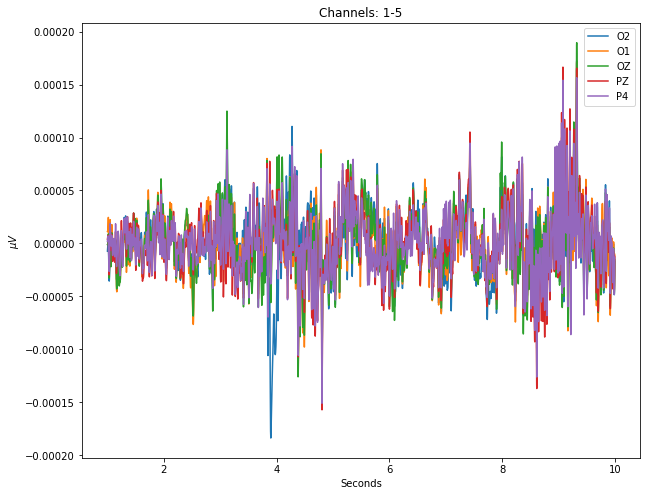

In [19]:
# Extract data from the first 5 channels, from 1 s to 10 s.
sfreq = data_raw.info['sfreq']
data, times = data_raw[:5, int(sfreq * 1):int(sfreq * 10)]

fig = plt.subplots(figsize=(10,8))
plt.plot(times, data.T)
plt.xlabel('Seconds')
plt.ylabel('$\mu V$')
plt.title('Channels: 1-5')
plt.legend(data_raw.ch_names[:5])

### mne plots
There are many nice plotting options included in mne. They are, however, not always interactive and fully functional in Jupyter notebooks... so better try them out from a python script.

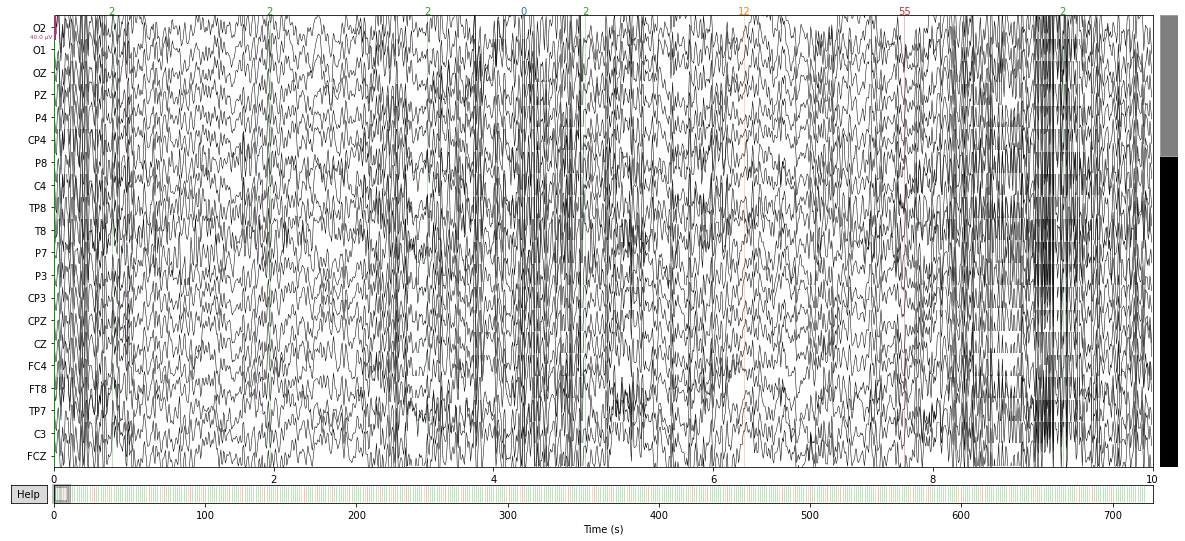

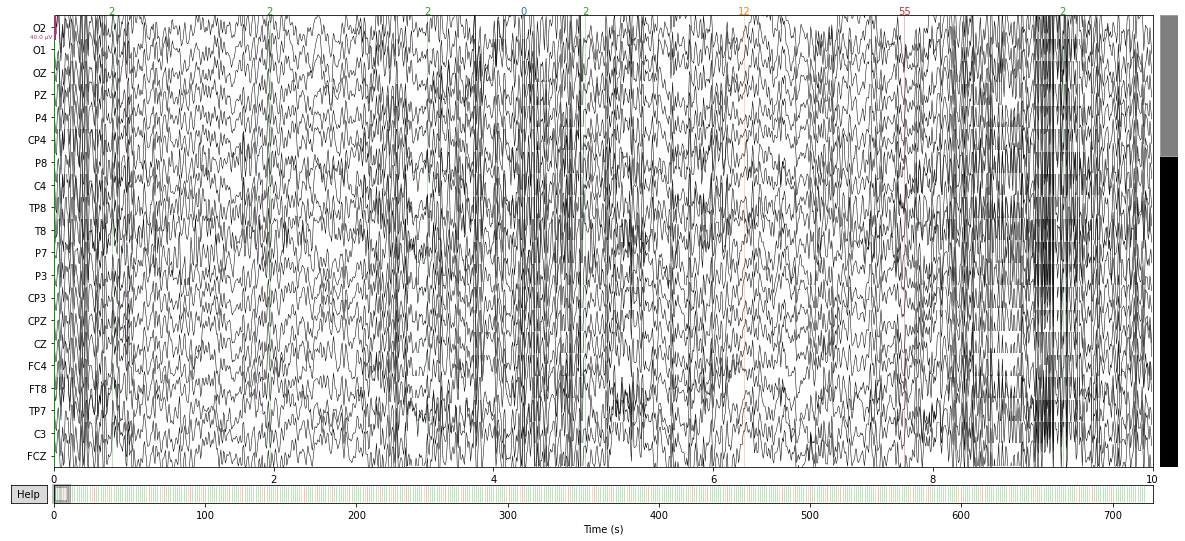

In [20]:
data_raw.plot(duration=10, block=True)

### Look at events 

In [21]:
# get the events
events, event_id = mne.events_from_annotations(data_raw)
print(events[:10,:])
print(event_id)

Used Annotations descriptions: ['0', '12', '2', '55']
[[ 263    0    3]
 [ 982    0    3]
 [1700    0    3]
 [2139    0    1]
 [2418    0    3]
 [3140    0    2]
 [3869    0    4]
 [4591    0    3]
 [5317    0    3]
 [6039    0    3]]
{'0': 1, '12': 2, '2': 3, '55': 4}


In [22]:
# Check which unique event indentifiers there are
unique_event_types = set(events[:,2])
print(unique_event_types)

{1, 2, 3, 4}


### Display signal around one type of event
Selects signal for specific event ID and plots time window from tmin to tmax.

In [23]:
# event_id = [1, 2, 3, 4] # select events for the given event IDs
tmin = -0.2  # start of each epoch (200ms before the trigger)
tmax = 0.5  # end of each epoch (500ms after the trigger)

baseline = (None, 0)  # means from the first instant to t = 0
picks = mne.pick_types(data_raw.info, meg=False, eeg=True, stim=False, eog=False, exclude='bads')

print(picks)

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63]


In [24]:
epochs = mne.Epochs(data_raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                    baseline=baseline, preload=True, verbose=True)

print(epochs)

Not setting metadata
Not setting metadata
501 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Loading data for 501 events and 351 original time points ...
0 bad epochs dropped
<Epochs |  501 events (all good), -0.2 - 0.5 sec, baseline [None, 0], ~83.3 MB, data loaded,
 '0': 1
 '12': 50
 '2': 400
 '55': 50>


In [25]:
# Export data in tabular structure as a pandas DataFrame.
epochs_df = epochs.to_data_frame()
epochs_df.head()

,time,condition,epoch,O2,O1,OZ,PZ,P4,CP4,P8,...,F2,F6,FC5,F1,AF4,AF8,F5,AF7,AF3,FPZ
0,-200,2,0,5.776277,21.552822,6.284413,9.826338,3.837707,10.712843,16.953423,...,21.723532,19.480235,16.863520,21.626617,27.187512,23.808257,9.203037,2.678933,27.306946,3.478671
1,-198,2,0,3.891065,18.730571,4.007459,7.967946,2.033432,8.940027,15.357137,...,21.098700,18.924694,14.186877,20.216267,26.949830,23.981909,4.974301,0.089015,23.120622,10.104687
2,-196,2,0,1.413661,15.727482,1.422303,6.046810,0.177996,7.091124,15.248225,...,19.649082,17.496024,10.683484,18.235636,25.147163,22.331764,1.506133,-1.224903,18.742386,15.040289
3,-194,2,0,-0.346193,13.507517,-0.403348,4.938111,-0.628492,6.208161,19.013304,...,18.257079,16.016415,7.630451,16.658495,22.707296,19.832320,0.198581,-0.191210,15.484061,18.513022
4,-192,2,0,-0.531538,12.504749,-0.915201,4.988503,0.138103,6.760605,27.446797,...,17.373527,14.944445,5.823127,15.989418,20.294435,17.306179,1.574888,3.581052,13.908921,20.799361


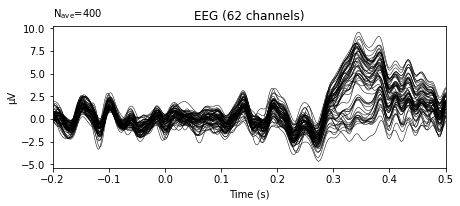

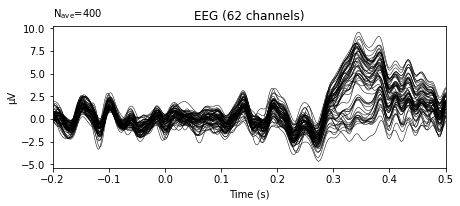

In [26]:
evoked = epochs['2'].average()
evoked.plot()

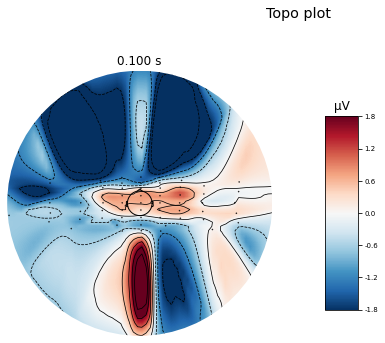

In [27]:
# Spatial plot:
evoked.plot_topomap(times=[0.1], size=3., title="Topo plot", time_unit='s');

### Plot topomaps for different time points

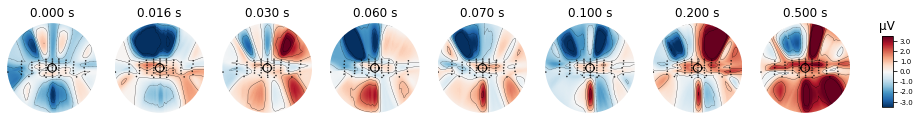

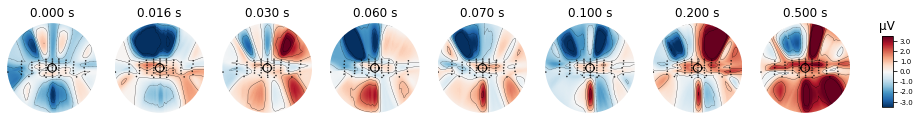

In [28]:
evoked.plot_topomap(times=np.array([0, 0.016, 0.030, 0.060, 0.070, 0.1, 0.2, 0.5]), time_unit='s')

### Test other event type

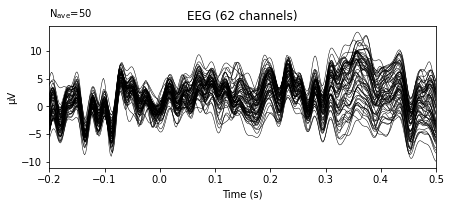

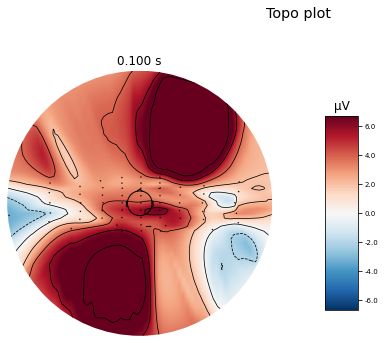

In [30]:
evoked = epochs['12'].average()
evoked.plot()
evoked.plot_topomap(times=[0.1], size=3., title="Topo plot", time_unit='s');

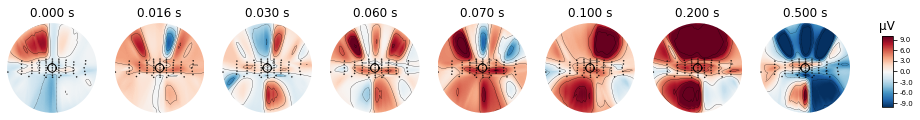

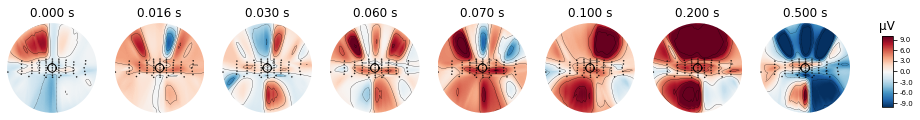

In [31]:
evoked.plot_topomap(times=np.array([0, 0.016, 0.030, 0.060, 0.070, 0.1, 0.2, 0.5]), time_unit='s')

## Custom cnt-file import function:

In [71]:
# def read_cnt_file(file,
#                   label_group,
#                   event_idx = [3, 13, 66],
#                   channel_set = "30",
#                   tmin = -0.2,
#                   tmax = 0.8,
#                   lpass = 0.5, 
#                   hpass = 40, 
#                   threshold = 5, 
#                   max_bad_fraction = 0.2):
#     """ Function to read cnt file. Run bandpass filter. 
#     Then detect and correct/remove bad channels and bad epochs.
#     Store resulting epochs as arrays.
    
#     Args:
#     --------
#     file: str
#         Name of file to import.
#     label_group: int
#         Unique ID of specific group (must be >0).
#     channel_set: str
#         Select among pre-defined channel sets. Here: "30" or "62"
#     """
    
#     if channel_set == "30":
#         channel_set = ['O2', 'O1', 'OZ', 'PZ', 'P4', 'CP4', 'P8', 'C4', 'TP8', 'T8', 'P7', 
#                        'P3', 'CP3', 'CPZ', 'CZ', 'FC4', 'FT8', 'TP7', 'C3', 'FCZ', 'FZ', 
#                        'F4', 'F8', 'T7', 'FT7', 'FC3', 'F3', 'FP2', 'F7', 'FP1']
#     elif channel_set == "62":
#         channel_set = ['O2', 'O1', 'OZ', 'PZ', 'P4', 'CP4', 'P8', 'C4', 'TP8', 'T8', 'P7', 
#                        'P3', 'CP3', 'CPZ', 'CZ', 'FC4', 'FT8', 'TP7', 'C3', 'FCZ', 'FZ', 
#                        'F4', 'F8', 'T7', 'FT7', 'FC3', 'F3', 'FP2', 'F7', 'FP1', 'AFZ', 'PO3', 
#                        'P1', 'POZ', 'P2', 'PO4', 'CP2', 'P6', 'M1', 'CP6', 'C6', 'PO8', 'PO7', 
#                        'P5', 'CP5', 'CP1', 'C1', 'C2', 'FC2', 'FC6', 'C5', 'FC1', 'F2', 'F6', 
#                        'FC5', 'F1', 'AF4', 'AF8', 'F5', 'AF7', 'AF3', 'FPZ']
#     else:
#         print("Predefined channel set given by 'channel_set' not known...")
        
    
#     # Initialize array
#     signal_collection = np.zeros((0,len(channel_set),501))
#     label_collection = np.zeros((0))
    
#     # Import file 
#     try:
#         data_raw = mne.io.read_raw_cnt(file, eog='auto', preload=True)
#     except ValueError:
#         print("ValueError")
#         print("Could not load file:", file)
#         return None, None
    
#     # Band-pass filter (between 0.5 and 40 Hz. was 0.5 to 30Hz in Stober 2016)
#     data_raw.filter(0.5, 40, fir_design='firwin')

#     # Get events from annotations in the data
#     events, event_dict = mne.events_from_annotations(data_raw, verbose=False)
    
#     # Set baseline:
#     baseline = (None, 0)  # means from the first instant to t = 0

#     # Select channels to exclude (if any)
#     channels_exclude = [x for x in data_raw.ch_names if x not in channel_set]
#     channels_exclude = [x for x in channels_exclude if x not in ['HEOG', 'VEOG']]
    
#     for event_key in event_idx:
#         if str(event_key) in event_dict.keys():
#             event_id = event_dict[str(event_key)]
            
#             # Pick EEG channels 
#             picks = mne.pick_types(data_raw.info, meg=False, eeg=True, stim=False, eog=False,
#                                #exclude=data_exclude)#'bads'])
#                                    include=channel_set, exclude=channels_exclude)#'bads'])

#             epochs = mne.Epochs(data_raw, events, event_id, tmin, tmax, proj=True, picks=picks,
#                             baseline=baseline, preload=True, verbose=False)

#             # Detect potential bad channels and epochs
#             bad_channels, bad_epochs = helper_functions.select_bad_epochs(epochs, 
#                                                                           event_id, 
#                                                                           threshold = threshold, 
#                                                                           max_bad_fraction = max_bad_fraction)

#             # Interpolate bad channels
#             if len(bad_channels) > 0:                 
#                 # Mark bad channels:
#                 data_raw.info['bads'] = bad_channels
#                 # Pick EEG channels:
#                 picks = mne.pick_types(data_raw.info, meg=False, eeg=True, stim=False, eog=False,
#                                    #exclude=data_exclude)#'bads'])
#                                    include=channel_set, exclude=channels_exclude)#'bads'])
#                 epochs = mne.Epochs(data_raw, events, event_id, tmin, tmax, proj=True, picks=picks,
#                                 baseline=baseline, preload=True, verbose=False)
#                 # Interpolate bad channels using functionality of 'mne'
#                 epochs.interpolate_bads()

#             # Get signals as array and add to total collection
#             signals_cleaned = epochs[str(event_id)].drop(bad_epochs).get_data()
#             signal_collection = np.concatenate((signal_collection, signals_cleaned), axis=0)
#             label_collection = np.concatenate((label_collection, event_id*label_group*np.ones((signals_cleaned.shape[0]))), axis=0)

#     return signal_collection, label_collection.astype(float)

In [110]:
def read_cnt_file(file,
                  label_group,
                  event_idx = [3, 13, 66],
                  channel_set = "30",
                  tmin = -0.2,
                  tmax = 0.8,
                  lpass = 0.5, 
                  hpass = 40, 
                  threshold = 5, 
                  max_bad_fraction = 0.2,
                  max_bad_channels = 2):
    """ Function to read cnt file. Run bandpass filter. 
    Then detect and correct/remove bad channels and bad epochs.
    Store resulting epochs as arrays.
    
    Args:
    --------
    file: str
        Name of file to import.
    label_group: int
        Unique ID of specific group (must be >0).
    channel_set: str
        Select among pre-defined channel sets. Here: "30" or "62"
    """
    
    if channel_set == "30":
        channel_set = ['O2', 'O1', 'OZ', 'PZ', 'P4', 'CP4', 'P8', 'C4', 'TP8', 'T8', 'P7', 
                       'P3', 'CP3', 'CPZ', 'CZ', 'FC4', 'FT8', 'TP7', 'C3', 'FCZ', 'FZ', 
                       'F4', 'F8', 'T7', 'FT7', 'FC3', 'F3', 'FP2', 'F7', 'FP1']
    elif channel_set == "62":
        channel_set = ['O2', 'O1', 'OZ', 'PZ', 'P4', 'CP4', 'P8', 'C4', 'TP8', 'T8', 'P7', 
                       'P3', 'CP3', 'CPZ', 'CZ', 'FC4', 'FT8', 'TP7', 'C3', 'FCZ', 'FZ', 
                       'F4', 'F8', 'T7', 'FT7', 'FC3', 'F3', 'FP2', 'F7', 'FP1', 'AFZ', 'PO3', 
                       'P1', 'POZ', 'P2', 'PO4', 'CP2', 'P6', 'M1', 'CP6', 'C6', 'PO8', 'PO7', 
                       'P5', 'CP5', 'CP1', 'C1', 'C2', 'FC2', 'FC6', 'C5', 'FC1', 'F2', 'F6', 
                       'FC5', 'F1', 'AF4', 'AF8', 'F5', 'AF7', 'AF3', 'FPZ']
    else:
        print("Predefined channel set given by 'channel_set' not known...")
        
    
    # Initialize array
    signal_collection = np.zeros((0,len(channel_set),501))
    label_collection = [] #np.zeros((0))
    channel_names_collection = []
    
    # Import file
    try:
        data_raw = mne.io.read_raw_cnt(file, eog='auto', preload=True)
    except ValueError:
        print("ValueError")
        print("Could not load file:", file)
        return None, None, None
    
    # Band-pass filter (between 0.5 and 40 Hz. was 0.5 to 30Hz in Stober 2016)
    data_raw.filter(0.5, 40, fir_design='firwin')

    # Get events from annotations in the data
    events_from_annot, event_dict = mne.events_from_annotations(data_raw)
    
    # Set baseline:
    baseline = (None, 0)  # means from the first instant to t = 0

    # Select channels to exclude (if any)
    channels_exclude = [x for x in data_raw.ch_names if x not in channel_set]
    channels_exclude = [x for x in channels_exclude if x not in ['HEOG', 'VEOG']]
    
    for event_id in event_idx:
        if str(event_id) in event_dict:
            # Pick EEG channels
            picks = mne.pick_types(data_raw.info, meg=False, eeg=True, stim=False, eog=False,
                               #exclude=data_exclude)#'bads'])
                                   include=channel_set, exclude=channels_exclude)#'bads'])

            epochs = mne.Epochs(data_raw, events=events_from_annot, event_id=event_dict,
                                tmin=tmin, tmax=tmax, proj=True, picks=picks,
                                baseline=baseline, preload=True, event_repeated='merge', verbose=False)

            # Detect potential bad channels and epochs
            bad_channels, bad_epochs = helper_functions.select_bad_epochs(epochs,
                                                                          event_id,
                                                                          threshold = threshold,
                                                                          max_bad_fraction = max_bad_fraction)

            # Interpolate bad channels
            # ------------------------------------------------------------------
            if len(bad_channels) > 0:
                if len(bad_channels) > max_bad_channels:
                    print(20*'--')
                    print("Found too many bad channels (" + str(len(bad_channels)) + ")")
                    return None, None, None
                else:
                    # Mark bad channels:
                    data_raw.info['bads'] = bad_channels
                    # Pick EEG channels:
                    picks = mne.pick_types(data_raw.info, meg=False, eeg=True, stim=False, eog=False,
                                       #exclude=data_exclude)#'bads'])
                                       include=channel_set, exclude=channels_exclude)#'bads'])
                    epochs = mne.Epochs(data_raw, events=events_from_annot, event_id=event_dict,
                                        tmin=tmin, tmax=tmax, proj=True, picks=picks,
                                        baseline=baseline, preload=True, verbose=False)
                    
                    print(20*'--')
                    print("INTERPOLATING BAD CHANNELS")
                    # Interpolate bad channels using functionality of 'mne'
                    epochs.interpolate_bads(mode='fast') # RuntimeError: Cannot fit headshape without digitization , info["dig"] is None
                    
#                     try:
#                         epochs.interpolate_bads()
#                     except RuntimeError:
#                         print(20*'--')
#                         print("RuntimeError")
#                         return None, None, None

            # Get signals as array and add to total collection
            channel_names_collection.append(epochs.ch_names)
            signals_cleaned = epochs[str(event_id)].drop(bad_epochs).get_data()
            signal_collection = np.concatenate((signal_collection, signals_cleaned), axis=0)
            label_collection += [event_id + label_group] * signals_cleaned.shape[0]

    return signal_collection, label_collection, channel_names_collection

In [86]:
signal_collect, label_collect, channel_names_collection = read_cnt_file(merged_df['cnt_path'][0], 
                                                          merged_df['age_months'][0],
                                                          event_idx = [3, 13, 66],
                                                          channel_set = "30",
                                                          tmin = -0.2,
                                                          tmax = 0.8,
                                                          lpass = 0.5, 
                                                          hpass = 40, 
                                                          threshold = 5, 
                                                          max_bad_fraction = 0.2)

Reading 0 ... 1500919  =      0.000 ...  3001.838 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '14', '15', '18', '2', '3', '4', '48', '5', '55', '66', '77', '80', '88']
Found 55 bad epochs in a total of 15  channels.
Marked 55 bad epochs in a total of 450  epochs.
Found 6 bad epochs in a total of 6  channels.
Marked 6 bad epochs in a total of 50  epochs.


In [87]:
signal_collect.shape

(439, 30, 501)

In [88]:
len(label_collect)

439

## Check how many EEG channels the cnt-files feature... 

In [89]:
format_collection = []
for i, file in merged_df.head(10).iterrows():
    # Import file 
    print(f"IMPORTING FILE: {file['cnt_path']}")
    
    try:
        data_raw = mne.io.read_raw_cnt(file['cnt_path'], eog='auto', preload=True)
    except ValueError:
        print("ValueError")
        print("Could not load file:", file['cnt_path'])
        continue
    
    format_collection.append((i, len(data_raw.ch_names)))
    print(i, len(data_raw.ch_names))

IMPORTING FILE: /Volumes/Seagate Expansion Drive/ePodium/Data/17mnd mmn/001_17_jc_mmn36_slp_mmn25_slp_mmn47_slp_mmn58_slp.cnt
Reading 0 ... 1500919  =      0.000 ...  3001.838 secs...
0 64
IMPORTING FILE: /Volumes/Seagate Expansion Drive/ePodium/Data/17mnd mmn/005_17_jc_mmn36_slp_mmn25_slp_mmn47_mixed.cnt
Reading 0 ... 1120199  =      0.000 ...  2240.398 secs...
1 64
IMPORTING FILE: /Volumes/Seagate Expansion Drive/ePodium/Data/17mnd mmn/006_17_mc_mmn36_slp.cnt
Reading 0 ... 1481999  =      0.000 ...  2963.998 secs...
2 64
IMPORTING FILE: /Volumes/Seagate Expansion Drive/ePodium/Data/17mnd mmn/007_17_jc_mmn.cnt
ValueError
Could not load file: /Volumes/Seagate Expansion Drive/ePodium/Data/17mnd mmn/007_17_jc_mmn.cnt
IMPORTING FILE: /Volumes/Seagate Expansion Drive/ePodium/Data/17mnd mmn/007_17_jc_mmn2.cnt
Reading 0 ... 618439  =      0.000 ...  1236.878 secs...
4 64
IMPORTING FILE: /Volumes/Seagate Expansion Drive/ePodium/Data/17mnd mmn/008_17_jc_mmn.cnt
Reading 0 ... 449859  =      0.0

In [90]:
a,b = zip(*format_collection)
len(np.where((np.array(b) == 64))[0]), len(np.where((np.array(b) == 32))[0]), len(a)

(9, 0, 9)

In [99]:
# number of cnt files which have both 65 channels (62 EEG) AND a label.
len(np.where((np.array(b) == 64) & (np.array(labels_type) == 1))[0])

NameError: name 'labels_type' is not defined

So far we 'only' have about 60 cnt-files of which we have a label ("risk group" vs "no risc group").
And only 42 of them feature 62 EEG channels. I hence switched to 30 EEG channels and picked the ones that are present in all patient datasets.

# Workflow data processing
1. Load cnt files.
2. Select same number of channels (here: 30 same channels which exist for both 30 and 62 channel data)
3. Preprocess raw data (bandpass + detect outliers and 'bad' epochs).
4. Store epoch data and event type as array

In [111]:
# Initialize array
signal_collection = np.zeros((0,30,501)) #62
label_collection = np.zeros((0))
metadata_collection = []

# for i, file in merged_df.head(2).iterrows():
for i, file in merged_df.iterrows():
    target = file['age_months']

    print(40*"=")
    print("Importing file: ", file['cnt_file'])
    print("Data belongs into group: ", target)

    # Import data and events
    filename = file['cnt_path']

    signal_collect, label_collect, ch_names = read_cnt_file(filename, 
                                                            target,
                                                            event_idx = [3, 13, 66],
                                                            channel_set = "30",
                                                            tmin = -0.2,
                                                            tmax = 0.8,
                                                            lpass = 0.5, 
                                                            hpass = 40, 
                                                            threshold = 5, 
                                                            max_bad_fraction = 0.2,
                                                            max_bad_channels = 2)
    if signal_collect is not None:
        # Get signals as array and add to total collection
        signal_collection = np.concatenate((signal_collection, signal_collect), axis=0)
        label_collection = np.concatenate((label_collection, label_collect), axis=0)
        metadata_collection.append((i, file['cnt_file'], signal_collection.shape[0]))


Importing file:  001_17_jc_mmn36_slp_mmn25_slp_mmn47_slp_mmn58_slp
Data belongs into group:  17.0
Reading 0 ... 1500919  =      0.000 ...  3001.838 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (6.602 sec)

Used Annotations descriptions: ['0', '12', '14', '15', '18', '2', '3', '4', '48', '5', '55', '66', '77', '80', '88']
Found 55 bad epochs in a total of 15  channels.
Marked 55 bad epochs in a total of 450  epochs.
Found 6 bad epochs in a total of 6  channels.
Marked 6 bad epochs

RuntimeError: Cannot fit headshape without digitization , info["dig"] is None

In [105]:
signal_collection.shape, label_collection.shape

((3684, 30, 501), (3684,))

In [104]:
metadata_collection[:10]

[(0, '001_17_jc_mmn36_slp_mmn25_slp_mmn47_slp_mmn58_slp', 439),
 (1, '005_17_jc_mmn36_slp_mmn25_slp_mmn47_mixed', 939),
 (2, '006_17_mc_mmn36_slp', 1432),
 (4, '007_17_jc_mmn2', 1432),
 (6, '008_17_jc_mmn2', 1913),
 (7, '009_17_jc_mmn36_wk_mmn25_wk', 2360),
 (8, '010_17_jc_mmn36_wk_mmn25_wk_mmn47_wk_mmn58_wk', 2714),
 (9, '015_17_jc_mmn25_wk', 2714),
 (10, '015_17_jc_mmn36_wk', 3206),
 (11, '017_17_jc_mmn25_wk', 3206)]

# ALL BEWLOW IS OLD:

We hence get a dataset of 39083 datapoints with known label.  
Each datapoint consits of a 1-second EEG signal of 30 channels with a 500Hz sampling rate. Thus arrays with a size of 30 x 501. 

## Labels 
Here we have 6 labels. 
1. Group 1, stimuli 3 --> "3"
2. Group 1, stimuli 13 --> "13"
3. Group 1, stimuli 66 --> "66"
4. Group 2, stimuli 3 --> "6"
5. Group 2, stimuli 13 --> "26"
6. Group 2, stimuli 66 --> "132"

In [228]:
# label_collection[1500:2000].astype(int)

array([], dtype=int64)

# Save entire processed dataset:

In [75]:
# filename = PATH_OUTPUT + "EEG_data_30channels_1s_corrected.npy"
# np.save(filename, signal_collection)

# filename = PATH_OUTPUT + "EEG_data_30channels_1s_corrected_labels.npy"
# np.save(filename, label_collection)

# import csv
# filename = PATH_OUTPUT + "EEG_data_30channels_1s_corrected_metadata.csv"

# with open(filename, 'w') as csvFile:
#     writer = csv.writer(csvFile)
#     writer.writerows(metadata_collection)
# csvFile.close()